# TalkingData AdTracking 
This dataset is huge , one of the biggest i have ever seen.

For this dataset, the objective is to predict whether a user will download an app after clicking a mobile app advertisement. Since, they have given a small training sample, we will first explore the dataset using this sample training set.

First let us import the necessary libraries and have a look at the data



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os 
import gc

train=pd.read_csv('data/mnt_sample/ssd/kaggle-talkingdata2/competition_files/train_sample.csv')
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [2]:
train.shape

(100000, 8)

## Data fields

Each row of the training data contains a click record, with the following features.

- ip: ip address of click.
- app: app id for marketing.
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- click_time: timestamp of click (UTC)
- attributed_time: if user download the app for after clicking an ad, this is the time of the app download
- is_attributed: the target that is to be predicted, indicating the app was downloaded
Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

- click_id: reference for making predictions
- is_attributed: not included


The evaluation metric used is ROC curve, the AUC of the ROC graph. Let us have a look at the actual train and test set below 

In [3]:
#let us have a look at the file sizes and the no of data points in them
for f in os.listdir('data/'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('data/' + f) / 1000000, 2)) + 'MB')


mnt_sample                    0.0MB
mnt                           0.0MB
sample_submission.csv         195.58MB
test.csv                      863.27MB
train.csv                     7537.65MB


we can just discard attributed_time ,as it adds no value with the presence of click_time. let us use only vital features and optimize memory by optimizing the dtypes

In [4]:
train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }


In [5]:
train_df = pd.read_csv('data/train.csv',nrows=40000000,usecols=train_columns,dtype=dtypes)

In [6]:
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [11]:
def show_mem_usage():
    '''Displays memory usage from inspection
    of global variables in this notebook'''
    gl = sys._getframe(1).f_globals
    vars= {}
    for k,v in list(gl.items()):
        # for pandas dataframes
        if hasattr(v, 'memory_usage'):
            mem = v.memory_usage(deep=True)
            if not np.isscalar(mem):
                mem = mem.sum()
            vars.setdefault(id(v),[mem]).append(k)
        # work around for a bug
        elif isinstance(v,pd.Panel):
            v = v.values
        vars.setdefault(id(v),[sys.getsizeof(v)]).append(k)
    total = 0
    for k,(value,*names) in vars.items():
        if value>1e6:
            print(names,"%.3fMB"%(value/1e6))
        total += value
    print("%.3fMB"%(total/1e6))

In [13]:
import sys
show_mem_usage()

['train', 'train'] 15.610MB
['train_df', 'train_df'] 3560.000MB
3575.616MB


In [14]:
test_df=pd.read_csv('data/test.csv',usecols=test_columns,dtype=dtypes)

In [15]:
test_df.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


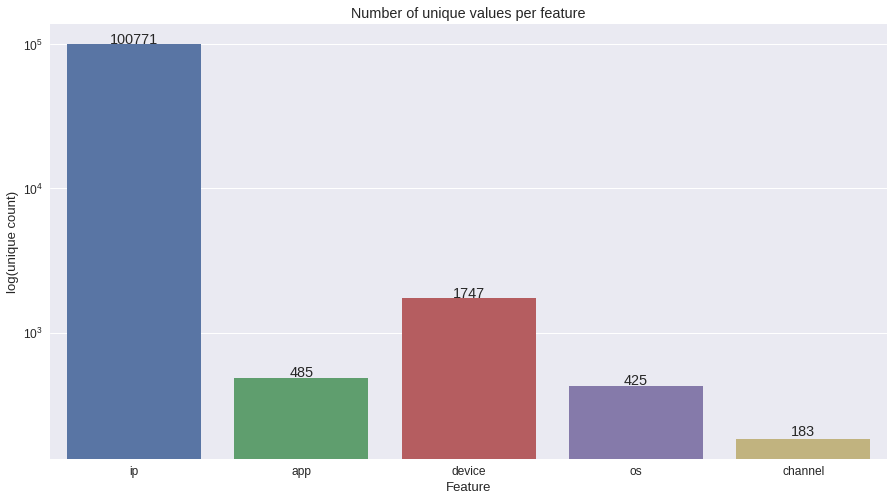

In [16]:
#plotting unique features
plt.figure(figsize=(15,8))
cols=['ip','app','device','os','channel']
unique_list=[len(train_df[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, unique_list, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, unique_list):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

In [17]:
train_df.describe()

,ip,app,device,os,channel,is_attributed
count,4.000000e+07,4.000000e+07,4.000000e+07,4.000000e+07,4.000000e+07,4.000000e+07
mean,8.686829e+04,1.229771e+01,3.605686e+01,2.508594e+01,2.671749e+02,2.580850e-03
std,5.593250e+04,1.570868e+01,3.229184e+02,6.416385e+01,1.282211e+02,5.073647e-02
min,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.128500e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.450000e+02,0.000000e+00
50%,8.145900e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.580000e+02,0.000000e+00
75%,1.213030e+05,1.500000e+01,1.000000e+00,1.900000e+01,3.790000e+02,0.000000e+00
max,2.127740e+05,6.760000e+02,3.545000e+03,7.470000e+02,4.980000e+02,1.000000e+00


### All the below distributions are meaningless as these are encoded variables which have different id's. Let us have a look though

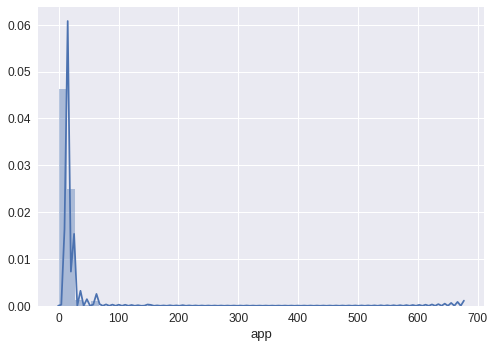

In [18]:
x=pd.Series(train_df['app'])
ax=sns.distplot(x)

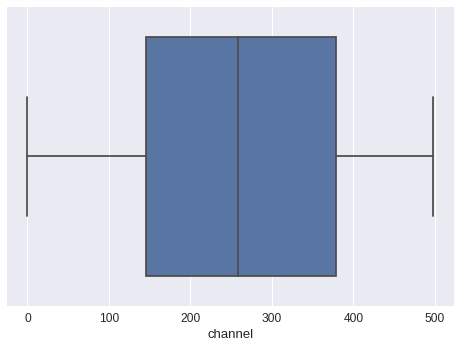

In [19]:
sns.boxplot(train_df['channel'])

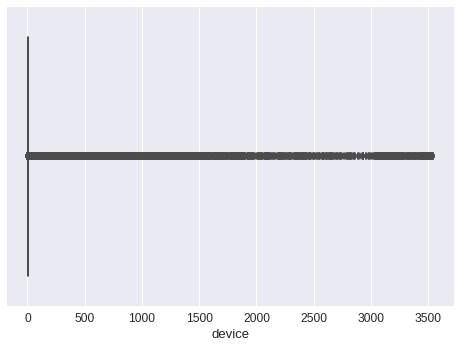

In [20]:
sns.boxplot(train_df['device'])

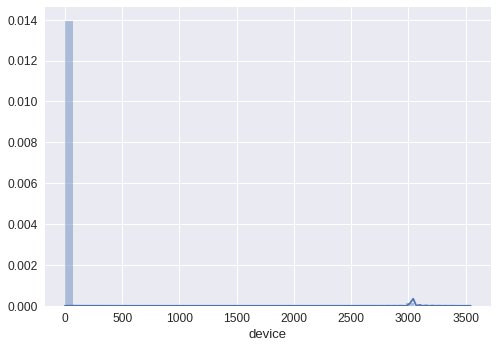

In [21]:
sns.distplot(train_df['device'])

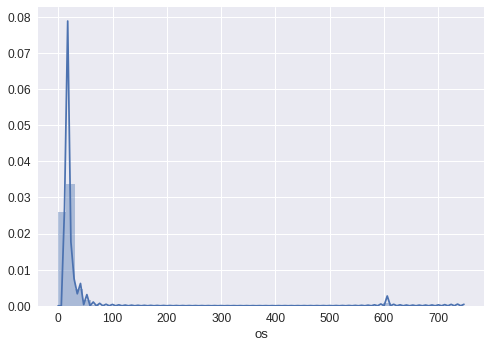

In [22]:
sns.distplot(train_df['os'])

### Let's have a look at the sample distribution of the target variable

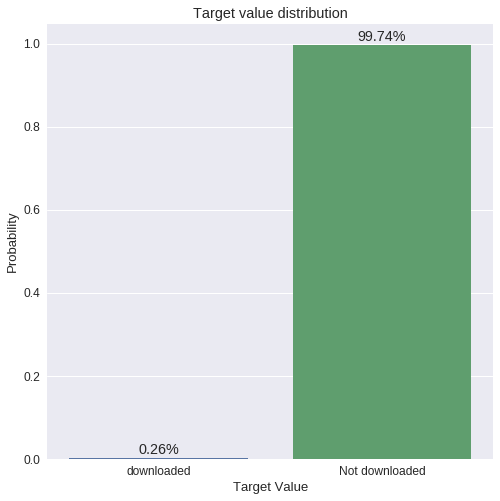

In [23]:
#plotting target variable distribution
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)
mean = (train_df.is_attributed.values == 1).mean()
ax = sns.barplot(['downloaded','Not downloaded'], [mean, 1-mean])
ax.set(xlabel='Target Value', ylabel='Probability', title='Target value distribution')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center") 

We can see that the data is highly unbalanced, with the first 40 million rows only 0.26% of clicks leading to downloads. We will need to use feature engineering to create more features using click_time and possibly discard attributed_time, because that will be registered in click_time

In [24]:
#creating time features
import datetime as dt
import time

#credits to https://www.kaggle.com/joaopmpeinado/single-xgboost-lb-0-965
def time_features(df):
    # Make some new features with click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['dow']      = df['datetime'].dt.dayofweek
    df["doy"]      = df["datetime"].dt.dayofyear
    #df["dteom"]    = df["datetime"].dt.daysinmonth - df["datetime"].dt.day
    df.drop(['click_time', 'datetime'], axis=1, inplace=True)
    return df


In [25]:
show_mem_usage()

['train', 'train'] 15.610MB
['train_df', 'train_df'] 3560.000MB
['test_df', 'test_df'] 1728.723MB
['x', 'x'] 80.000MB
5384.345MB


In [26]:
y=train_df['is_attributed']
train_df.drop(['is_attributed'],axis=1,inplace=True)

In [27]:
train_df.head()

,ip,app,device,os,channel,click_time
0,83230,3,1,13,379,2017-11-06 14:32:21
1,17357,3,1,19,379,2017-11-06 14:33:34
2,35810,3,1,13,379,2017-11-06 14:34:12
3,45745,14,1,13,478,2017-11-06 14:34:52
4,161007,3,1,13,379,2017-11-06 14:35:08


In [28]:
import gc 
# Drop IP and ID from test rows
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype('int')
test_df.drop(['click_id'], axis=1, inplace=True)
gc.collect()

11114

In [29]:
len_train = len(train_df)
train_df=train_df.append(test_df)

del test_df
gc.collect()


38

In [30]:
print('data prep...')
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
del train_df['click_time']
gc.collect()

data prep...


14

In [31]:
show_mem_usage()


['train', 'train'] 15.610MB
['train_df', 'train_df'] 1234.600MB
['x', 'x'] 80.000MB
['y', 'y'] 40.000MB
['sub', 'sub'] 150.324MB
1520.547MB


In [32]:
test_df = train_df[len_train:]
print(len(test_df))
val_df = train_df[(len_train-2000000):len_train]
print(len(val_df))
train_df = train_df[:(len_train-2000000)]
print(len(train_df))



18790469
2000000
38000000


In [33]:
train_df.head()

,ip,app,device,os,channel,hour
0,83230,3,1,13,379,14
1,17357,3,1,19,379,14
2,35810,3,1,13,379,14
3,45745,14,1,13,478,14
4,161007,3,1,13,379,14


In [34]:
test_df.head()

,ip,app,device,os,channel,hour
0,5744,9,1,3,107,4
1,119901,9,1,3,466,4
2,72287,21,1,19,128,4
3,78477,15,1,13,111,4
4,123080,12,1,13,328,4


In [27]:
target = 'is_attributed'
predictors = ['app','device','os', 'channel', 'hour']
categorical = ['app','device','os', 'channel', 'hour']


In [35]:
y_train,y_val=y[:len(y)-2000000],y[len(y)-2000000:]
y_train.shape,y_val.shape

((38000000,), (2000000,))

In [36]:
del y
gc.collect()

41

In [37]:
show_mem_usage()

['train', 'train'] 15.610MB
['train_df', 'train_df'] 798.000MB
['x', 'x'] 80.000MB
['sub', 'sub'] 150.324MB
['test_df', 'test_df'] 394.600MB
['val_df', 'val_df'] 42.000MB
['y_train', 'y_train'] 38.000MB
['y_val', 'y_val'] 2.000MB
1520.548MB


In [38]:
from sklearn.metrics import auc,roc_curve
from sklearn.ensemble import RandomForestClassifier
clf1=RandomForestClassifier()


In [39]:
show_mem_usage()

['train', 'train'] 15.610MB
['train_df', 'train_df'] 798.000MB
['x', 'x'] 80.000MB
['sub', 'sub'] 150.324MB
['test_df', 'test_df'] 394.600MB
['val_df', 'val_df'] 42.000MB
['y_train', 'y_train'] 38.000MB
['y_val', 'y_val'] 2.000MB
1520.550MB


In [40]:
start=time.time()
clf1.fit(train_df,y_train)
end=time.time()
print("Time to fit:{}".format(end-start))

MemoryError: 

In [30]:
import lightgbm as lgb
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.08,
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 8,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, xgtrain, valid_sets=[xgtrain, xgvalid], valid_names=['train','valid'], evals_result=evals_results, num_boost_round=num_boost_round,
                      early_stopping_rounds=early_stopping_rounds,
                      verbose_eval=10, feval=feval)

    n_estimators = bst1.best_iteration
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics+":", evals_results['valid'][metrics][n_estimators-1])

    #ax = lgb.plot_importance(bst1,max_num_features=60)
    #plt.show()

    return bst1


In [34]:

print("Training...")
params = {
    'learning_rate': 0.2,
    'num_leaves': 1400,  # we should let it be smaller than 2^(max_depth)
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': .8,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':80
}
bst = lgb_modelfit_nocv(params, train_df, val_df, predictors,, objective='binary', metrics='auc',
                        early_stopping_rounds=40, verbose_eval=True, num_boost_round=500, categorical_features=categorical)



Training...
preparing validation datasets


KeyError: '[0 0 0 ..., 0 0 0] not in index'

In [29]:
del train_df
del val_df
gc.collect()

print("Predicting...")
sub['is_attributed'] = bst.predict(test_df[predictors])
print("writing...")
sub.to_csv('lgb_sub_tint.csv',index=False)
print("done...")
print(sub.info())

MemoryError: 